<P> <img src="https://i.ibb.co/gyNf19D/nhslogo.png" alt="nhslogo" border="0" width="100" align="right"><font size="6"><b> CS5131</b> Introduction to Artificial Intelligence - Assignment 2</font>

# Utilising and Optimising Genetic Algorithms to Play Mastermind

I

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Task-1:-Mastermind" data-toc-modified-id="Task-1:-Mastermind-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Task 1: Mastermind</a></span></li><li><span><a href="#Task-2:-Genetic-Algorithm" data-toc-modified-id="Task-2:-Genetic-Algorithm-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Task 2: Genetic Algorithm</a></span></li></ul></div>

<h2>Set-up and Imports<span class="tocSkip"></span></h2>

In [4]:
import re
import time
from collections import Counter
from functools import reduce, partial
from itertools import tee, zip_longest
import np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Task 1: Mastermind

In [10]:
while True:
    try:
        code_type = input("ELECTRONIC MASTERMIND 1977\nSELECT CODE TYPE: [3, 4, 5]: ").strip()
        if code_type.lower() == "stop":
            print("Terminated", end="\n\n\n")
            break
        N = int(code_type)
        if N not in [3, 4, 5]: raise ValueError()
    except ValueError:
        print("Not a valid code type.", end="\n\n\n")
    else:
        shield = np.random.choice(10, N)
        print(shield, "NOTE: THIS SHOULD BE HIDDEN. IT IS SHOWN FOR DEMO PURPOSES ONLY")
        i = 0
        output = np.array(["."]*N)
        while (output != "B").any():
            try:
                ui = np.array(re.split(r"\s", input("Enter the code separated by space: "))).astype(int)
                if len(ui) != N: raise ValueError("Insufficient Values in Input")
            except ValueError as e:
                print(e if len(str(e)) and not str(e).startswith("invalid literal for int()") else "Unexpected Format for Sequence\n")
            else:
                output = np.array(["."]*N)
                output[np.isin(ui, list(set(shield[ui != shield]) & set(ui[ui != shield])))] = "W"
                output[ui==shield] = "B"
                i += 1
                print("Guess", i, ":", np.sum(output=="B"), np.sum(output=="W"), output,  end="\n\n")

        print("SOLVED:", shield, end="\n\n\n")

ELECTRONIC MASTERMIND 1977
SELECT CODE TYPE: [3, 4, 5]: 3
[6 7 1] NOTE: THIS SHOULD BE HIDDEN. IT IS SHOWN FOR DEMO PURPOSES ONLY
Enter the code separated by space: 1 2 3
Guess 1 : 0 1 ['W' '.' '.']

Enter the code separated by space: 4 5 6
Guess 2 : 0 1 ['.' '.' 'W']

Enter the code separated by space: 6 7 1
Guess 3 : 3 0 ['B' 'B' 'B']

SOLVED: [6 7 1]


ELECTRONIC MASTERMIND 1977
SELECT CODE TYPE: [3, 4, 5]: quit
Not a valid code type.


ELECTRONIC MASTERMIND 1977
SELECT CODE TYPE: [3, 4, 5]: stop
Terminated




## Task 2: Genetic Algorithm

In [41]:
def p(*size): return np.random.random(size=size if len(size) else 1)

def rand(*size): return np.random.randint(10, size=size if len(size) else 1)

def shuffle(arr):
    cp = arr.copy()
    np.random.shuffle(cp)
    return cp

class Chromosome:
    def __init__(self, *args):
        if len(args) == 1: args = args[0]
        self.values = np.array(list(map(int, args))).flatten()
        self.slots = len(self.values)
        
    def copy(self):
        return Chromosome(*self.values.tolist())
    
    def __str__(self):
        return f"Chromosome("+", ".join(map(str, self.values))+")"
    
    def __len__(self):
        return self.slots
    
    def __getitem__(self, i):
        return self.values[i]
    
    def __setitem__(self, i, obj):
        self.values[i] = obj
        
    def randSlots(self, size=1):
        return np.random.randint(self.slots-1, size=size)
        
    def tolist(self):
        return self.values.tolist()

    def stringify(self):
        return "".join(map(str, self.tolist()))
    
    @classmethod
    def destringify(cls, string):
        return cls(*map(int, string))
    
    def crossover(self, other):
        return Chromosome(np.where(p(self.slots)<0.5, self.values, other.values))
    
    def mutate(self):
        code = self.copy()
        if p() < 0.03:
            code[code.randSlots()] = rand()
        return code
    
    def invert(self):
        code = self.copy()
        if p() < 0.03:
            a, b = sorted(tuple(code.randSlots(2)))
            code[a:b] = code[a:b][::-1]
        return code
    
    def scramble(self):
        code = self.copy()
        if p() < 0.03:
            a, b = sorted(tuple(code.randSlots(2)))
            code[a:b] = shuffle(code[a:b])
        return code
    
    def swap(self,a,b):
        self[a], self[b] = self[b], self[a]

    def permute(self):
        code = self.copy()
        for i in range(code.slots):
            if p() < ppermute: # very low
                code.swap(*code.randSlots(2))
        return code
    
    def __hash__(self):
        return int(self.stringify())
    
    def __eq__(self, other):
        return (self.values == other.values).sum()
    
    def __ne__(self, other):
        return self.values != other.values
    
    def within(self, other):
        return np.isin(self.values, other) 
    
    def whites(self, guess):
        return guess.within(list(set(self[guess != self]) & set(guess[guess != self]))).astype(int)
       
    def blacks(self, guess):
        return (self.values == guess.values)
    
    def score(self, guess):
        return np[self == guess, guess.whites(self).sum()]
    
    def mark(self, guess):
        output = np.full_like(self.values, ".", dtype=str)
        output[guess.whites(self)] = "W"
        output[guess.blacks(self)] = "B"
        return output
    
    def markWith(self, optimal):
        guess = self.values.copy()+1
        code = optimal.values.copy()+1
        output = np.full_like(code, ".", dtype=str)
        output[guess == code] = "B"
        negatize = code * ((code != guess)*2 - 1)
        considerations = []

        for allele in guess[guess != code]:
            result = "."
            if allele in negatize:
                result = "W"
                negatize[np.argmax(negatize == allele)] = -allele
            considerations.append(result)

        output[guess != code] = considerations

        return output
    
    def scoreWith(self, optimal):
        output = self.markWith(optimal)
        return np[(output == "B").sum(), (output == "W").sum()]
    
    def fitness(self, guesses):
        return np.array([self.scoreWith(guess)-guess_result for (guess, guess_result) in guesses]).sum() #- self.slots

    
class ChromoSet(list):
    """
    Can be used for guesses, genotype, eligibles etc
    """
    def __init__(self, values=[]):
        self.values = [Chromosome(candidate) for candidate in np.array(values).tolist()]
        super().__init__(self.values)
        
    def __gt__(self, other):
        return len(self) > len(other)
    
    def __ge__(self, other):
        return len(self) >= len(other)
    
    def __lt__(self, other):
        return len(self) < len(other)
    
    def __le__(self, other):
        return len(self) <= len(other)
    
    def filter(self, f):
        return Elite([chromosome for chromosome in self if f(chromosome)])
    
    def tolist(self):
        return list(map(Chromosome.tolist, self))
        

class Elite(ChromoSet):
    def __add__(self, other):
        return Elite(list(set(self) | set(other)))
    def __sub__(self, other):
        return Elite(list(set(self) - set(other)))
    def __str__(self):
        return "["+", ".join(map(str, self))+"]"
    def __repr__(self):
        return "["+", ".join(map(str, self))+"]"
        
        
class Genotype(ChromoSet):
    def __init__(self, size, slots, initial=[]):
        self.size = size
        self.slots = slots
        df = pd.DataFrame(initial)
        while len(df) < size:
            pop = rand(size-len(df), slots)
            df = pd.concat([df, pd.DataFrame(pop)], ignore_index=True).drop_duplicates()
        
        super().__init__(df.iloc[:size].values)
        
    def reproduce(self):
        a, b = tee(self)
        next(b, None)
        return Genotype(len(self), len(self[0]), initial=list(map(lambda chromosomes: chromosomes[0].crossover(chromosomes[1]).mutate().invert().scramble().permute().tolist(), zip_longest(a, b, fillvalue=self[-1]))))
            
def train(guesses):
    pop = Genotype(150, 3)
    Ei = Elite()
    cnt = 0
    while cnt <= 100 and Ei <= pop:
        children = pop.reproduce().filter(lambda child: not child.fitness(guesses))
        if len(children):
            Ei = Ei + children
            pop = Genotype(150, 3, initial=list(map(Chromosome.tolist, Ei)))
        cnt += 1
    
    return Ei


code = Chromosome(rand(3))

init = Chromosome(1,2,3)

print("Code Played:", init)
print(init.scoreWith(code), init.markWith(code))
guesses = [(init, init.scoreWith(code))]

cnt = 1

while cnt <= 100 and guesses[-1][-1][0] != 3:
    Ei = train(guesses)
    if len(Ei) == 0: continue
    possibles = Ei - Elite([i[0].tolist() for i in guesses])
    #print("Elites:",possibles)
    submission = possibles[np.random.randint(len(possibles))]
    print("Code Played:", submission)
    print(submission.scoreWith(code), submission.markWith(code))
    guesses.append((submission, submission.scoreWith(code)))
    cnt += 1
    
print("YOU WIN!")

Code Played: Chromosome(1, 2, 3)
[1 1] ['B' 'W' '.']
Code Played: Chromosome(6, 1, 2)
[1 1] ['.' 'W' 'B']
Code Played: Chromosome(1, 8, 2)
[2 0] ['B' '.' 'B']
Code Played: Chromosome(1, 0, 2)
[2 0] ['B' '.' 'B']
Code Played: Chromosome(1, 2, 7)
[1 2] ['B' 'W' 'W']
Code Played: Chromosome(1, 2, 6)
[1 1] ['B' 'W' '.']
Code Played: Chromosome(2, 1, 3)
[0 2] ['W' 'W' '.']
Code Played: Chromosome(1, 7, 2)
[3 0] ['B' 'B' 'B']
YOU WIN!


In [40]:
print(Chromosome(rand(3)))

Chromosome(3, 7, 6)


ELECTRONIC MASTERMIND 1977
SELECT CODE TYPE: [3, 4, 5]: 4
Guess 0: 3 6 4 6
[0 0] ['.' '.' '.' '.']
#GEN 1 : 0.55
#GEN 2 : 0.36333333333333334
#GEN 3 : 0.19
Guess 1: 5 5 1 5
[1 0] ['.' '.' 'B' '.']


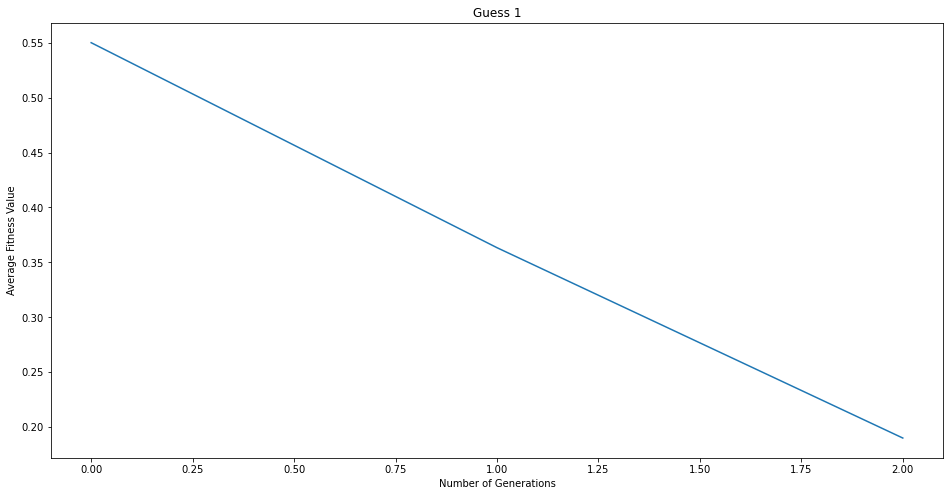

#GEN 1 : 0.5833333333333334
#GEN 2 : 0.5066666666666667
#GEN 3 : 0.5083333333333333
#GEN 4 : 0.4716666666666667
#GEN 5 : 0.41833333333333333
#GEN 6 : 0.36833333333333335
#GEN 7 : 0.31166666666666665
#GEN 8 : 0.24
#GEN 9 : 0.145
Guess 2: 5 0 9 0
[0 1] ['.' '.' 'W' '.']


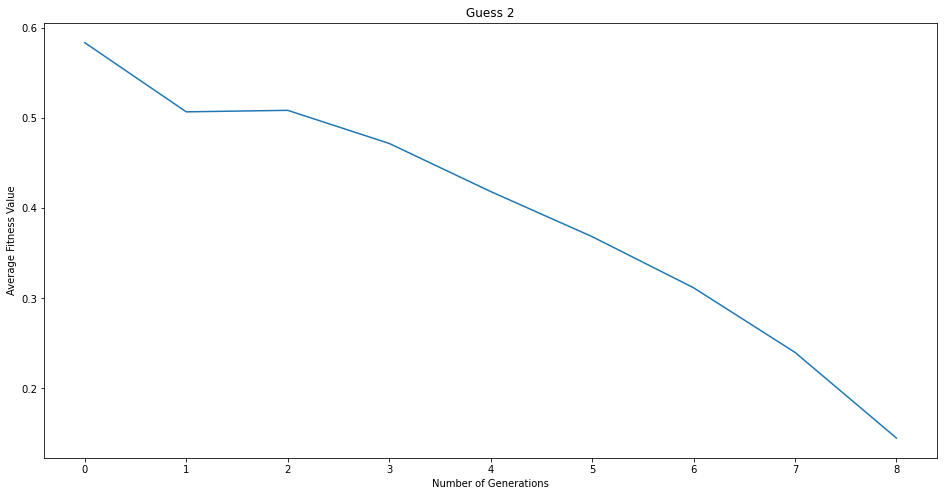

#GEN 1 : 0.5155555555555555
#GEN 2 : 0.5355555555555557
#GEN 3 : 0.5122222222222222
#GEN 4 : 0.5166666666666667
#GEN 5 : 0.4755555555555555
#GEN 6 : 0.46777777777777774
#GEN 7 : 0.4644444444444444
#GEN 8 : 0.4377777777777778
#GEN 9 : 0.43555555555555553
#GEN 10 : 0.46111111111111114
#GEN 11 : 0.4533333333333333
#GEN 12 : 0.4000000000000001
#GEN 13 : 0.40111111111111114
#GEN 14 : 0.37777777777777777
#GEN 15 : 0.34777777777777774
#GEN 16 : 0.31888888888888883
#GEN 17 : 0.30222222222222217
#GEN 18 : 0.33666666666666656
#GEN 19 : 0.2833333333333333
#GEN 20 : 0.2877777777777777
#GEN 21 : 0.25666666666666665
#GEN 22 : 0.24222222222222223
#GEN 23 : 0.25888888888888884
#GEN 24 : 0.2588888888888889
#GEN 25 : 0.23222222222222225
#GEN 26 : 0.22000000000000006
#GEN 27 : 0.23444444444444448
#GEN 28 : 0.19222222222222224
#GEN 29 : 0.2111111111111111
#GEN 30 : 0.21
#GEN 31 : 0.19777777777777777
#GEN 32 : 0.23
#GEN 33 : 0.20111111111111113
#GEN 34 : 0.19555555555555554
#GEN 35 : 0.22666666666666663
#G

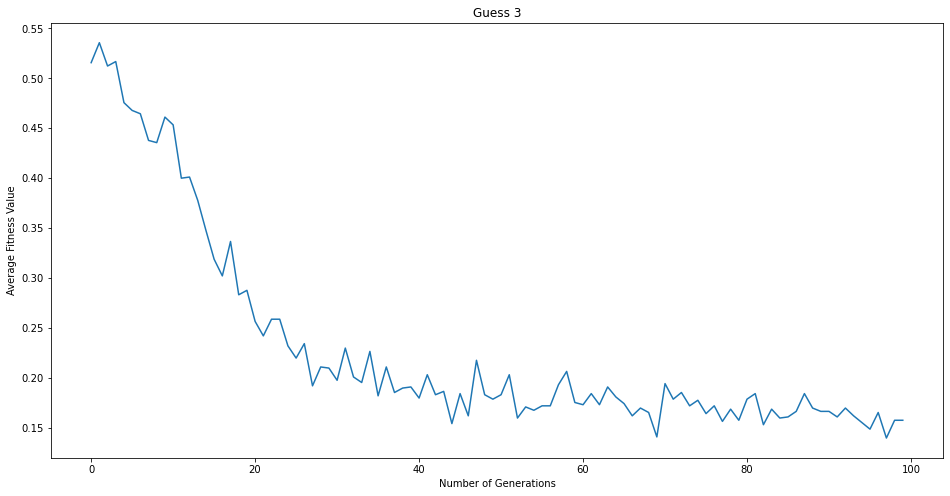

#GEN 1 : 0.7233333333333334
#GEN 2 : 0.7783333333333333
#GEN 3 : 0.7383333333333333
#GEN 4 : 0.7608333333333334
#GEN 5 : 0.7341666666666666
#GEN 6 : 0.7558333333333334
#GEN 7 : 0.7366666666666667
#GEN 8 : 0.7266666666666667
#GEN 9 : 0.7433333333333333
#GEN 10 : 0.7183333333333334
#GEN 11 : 0.7116666666666667
#GEN 12 : 0.6633333333333333
#GEN 13 : 0.69
#GEN 14 : 0.7
#GEN 15 : 0.6758333333333333
#GEN 16 : 0.7291666666666666
#GEN 17 : 0.7325
#GEN 18 : 0.725
#GEN 19 : 0.7041666666666667
#GEN 20 : 0.6925
#GEN 21 : 0.6816666666666666
#GEN 22 : 0.7058333333333333
#GEN 23 : 0.7016666666666667
#GEN 24 : 0.7375
#GEN 25 : 0.7058333333333333
#GEN 26 : 0.6708333333333333
#GEN 27 : 0.6741666666666667
#GEN 28 : 0.7258333333333333
#GEN 29 : 0.6983333333333334
#GEN 30 : 0.6816666666666666
#GEN 31 : 0.65
#GEN 32 : 0.665
#GEN 33 : 0.6991666666666667
#GEN 34 : 0.6975
#GEN 35 : 0.69
#GEN 36 : 0.6533333333333333
#GEN 37 : 0.6758333333333333
#GEN 38 : 0.6691666666666667
#GEN 39 : 0.6383333333333333
#GEN 40 :

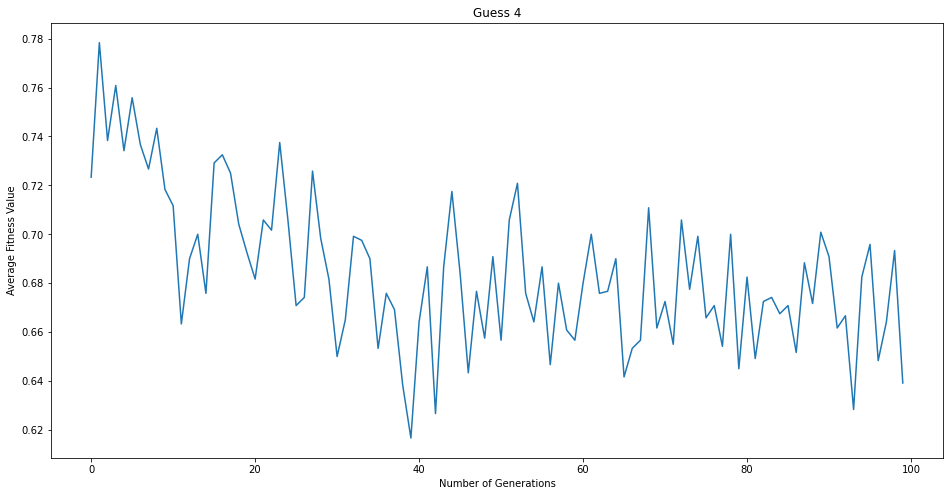

#GEN 1 : 0.654
#GEN 2 : 0.6920000000000001
#GEN 3 : 0.6706666666666669
#GEN 4 : 0.6666666666666666
#GEN 5 : 0.6693333333333333
#GEN 6 : 0.682
#GEN 7 : 0.656
#GEN 8 : 0.654
#GEN 9 : 0.7080000000000001
#GEN 10 : 0.644
#GEN 11 : 0.6426666666666666
#GEN 12 : 0.682
#GEN 13 : 0.6733333333333332
#GEN 14 : 0.6866666666666666
#GEN 15 : 0.6966666666666667
#GEN 16 : 0.6813333333333333
#GEN 17 : 0.6966666666666667
#GEN 18 : 0.6626666666666666
#GEN 19 : 0.7026666666666667
#GEN 20 : 0.6513333333333332
#GEN 21 : 0.6659999999999999
#GEN 22 : 0.6866666666666666
#GEN 23 : 0.6806666666666666
#GEN 24 : 0.7006666666666667
#GEN 25 : 0.6953333333333334
#GEN 26 : 0.6486666666666666
#GEN 27 : 0.7
#GEN 28 : 0.6426666666666667
#GEN 29 : 0.6539999999999999
#GEN 30 : 0.6806666666666666
#GEN 31 : 0.6726666666666666
#GEN 32 : 0.6393333333333334
#GEN 33 : 0.7113333333333335
#GEN 34 : 0.6593333333333333
#GEN 35 : 0.6546666666666667
#GEN 36 : 0.6593333333333333
#GEN 37 : 0.6839999999999999
#GEN 38 : 0.656
#GEN 39 : 0.6

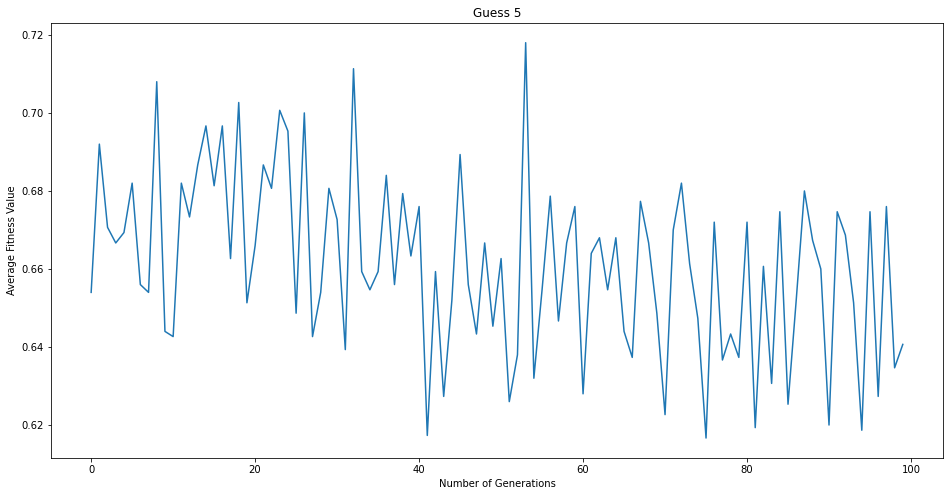

#GEN 1 : 0.8572222222222221
#GEN 2 : 0.8411111111111111
#GEN 3 : 0.8483333333333334
#GEN 4 : 0.8538888888888888
#GEN 5 : 0.8577777777777778
#GEN 6 : 0.8655555555555554
#GEN 7 : 0.8427777777777777
#GEN 8 : 0.831111111111111
#GEN 9 : 0.8711111111111111
#GEN 10 : 0.8477777777777777
#GEN 11 : 0.8527777777777777
#GEN 12 : 0.855
#GEN 13 : 0.8627777777777778
#GEN 14 : 0.8616666666666667
#GEN 15 : 0.8627777777777778
#GEN 16 : 0.8572222222222221
#GEN 17 : 0.8638888888888888
#GEN 18 : 0.8472222222222222
#GEN 19 : 0.8727777777777778
#GEN 20 : 0.8494444444444443
#GEN 21 : 0.816111111111111
#GEN 22 : 0.806111111111111
#GEN 23 : 0.8177777777777779
#GEN 24 : 0.806111111111111
#GEN 25 : 0.8266666666666667
#GEN 26 : 0.8211111111111111
#GEN 27 : 0.8366666666666664
#GEN 28 : 0.8194444444444445
#GEN 29 : 0.815
#GEN 30 : 0.8188888888888889
#GEN 31 : 0.8355555555555556
#GEN 32 : 0.805
#GEN 33 : 0.8344444444444444
#GEN 34 : 0.8505555555555556
#GEN 35 : 0.8377777777777777
#GEN 36 : 0.8516666666666667
#GEN 37 

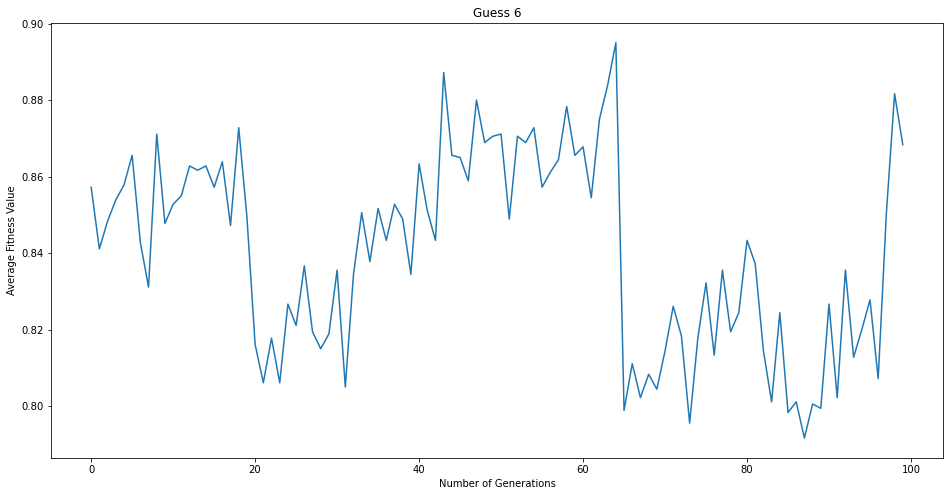

YOU WIN!


In [17]:
def p(*size): return np.random.random(size=size if len(size) else 1)

def rand(*size): return np.random.randint(10, size=size if len(size) else 1)

def shuffle(arr):
    cp = arr.copy()
    np.random.shuffle(cp)
    return cp

class Chromosome:
    CROSS_PROB = 0.5
    MUTATE_PROB = 0.03
    INVERT_PROB = 0.03
    SCRAMBLE_PROB = 0.03
    PERMUTE_PROB = 0.03
    
    @classmethod
    def reset(cls, cross = 0.5, mutate = 0.03, invert = 0.03, scramble = 0.03, permute = 0.03):
        cls.CROSS_PROB = cross
        cls.MUTATE_PROB = mutate
        cls.INVERT_PROB = invert
        cls.SCRAMBLE_PROB = scramble
        cls.PERMUTE_PROB = permute
    
    def __init__(self, *args):
        if len(args) == 1: args = args[0]
        self.values = np.array(list(map(int, args))).flatten()
        self.slots = len(self.values)
        
    def copy(self):
        return Chromosome(*self.values.tolist())
    
    def __str__(self):
        return f"Chromosome("+", ".join(map(str, self.values))+")"
    
    def __len__(self):
        return self.slots
    
    def __getitem__(self, i):
        return self.values[i]
    
    def __setitem__(self, i, obj):
        self.values[i] = obj
        
    def randSlots(self, size=1):
        return np.random.randint(self.slots-1, size=size)
        
    def tolist(self):
        return self.values.tolist()

    def stringify(self):
        return "".join(map(str, self.tolist()))
    
    @classmethod
    def destringify(cls, string):
        return cls(*map(int, string))
    
    def crossover(self, other):
        return Chromosome(np.where(p(self.slots)<self.CROSS_PROB, self.values, other.values))
    
    def mutate(self):
        code = self.copy()
        if p() < self.MUTATE_PROB:
            code[code.randSlots()] = rand()
        return code
    
    def invert(self):
        code = self.copy()
        if p() < self.INVERT_PROB:
            a, b = sorted(tuple(code.randSlots(2)))
            code[a:b] = code[a:b][::-1]
        return code
    
    def scramble(self):
        code = self.copy()
        if p() < self.SCRAMBLE_PROB:
            a, b = sorted(tuple(code.randSlots(2)))
            code[a:b] = shuffle(code[a:b])
        return code
    
    def swap(self,a,b):
        self[a], self[b] = self[b], self[a]

    def permute(self):
        code = self.copy()
        for i in range(code.slots):
            if p() < self.PERMUTE_PROB: # very low
                code.swap(*code.randSlots(2))
        return code
    
    def __hash__(self):
        return int(self.stringify())
    
    def __eq__(self, other):
        return (self.values == other.values).sum()
    
    def __ne__(self, other):
        return self.values != other.values
    
    def within(self, other):
        return np.isin(self.values, other) 
    
    def whites(self, guess):
        return guess.within(list(set(self[guess != self]) & set(guess[guess != self]))).astype(int)
       
    def blacks(self, guess):
        return (self.values == guess.values)
    
    def score(self, guess):
        return np[self == guess, guess.whites(self).sum()]
    
    def mark(self, guess):
        output = np.full_like(self.values, ".", dtype=str)
        output[guess.whites(self)] = "W"
        output[guess.blacks(self)] = "B"
        return output
    
    def markWith(self, optimal):
        guess = self.values.copy()+1
        code = optimal.values.copy()+1
        output = np.full_like(code, ".", dtype=str)
        output[guess == code] = "B"
        negatize = code * ((code != guess)*2 - 1)
        considerations = []

        for allele in guess[guess != code]:
            result = "."
            if allele in negatize:
                result = "W"
                negatize[np.argmax(negatize == allele)] = -allele
            considerations.append(result)

        output[guess != code] = considerations

        return output
    
    def scoreWith(self, optimal):
        output = self.markWith(optimal)
        return np[(output == "B").sum(), (output == "W").sum()]
    
    def fitness(self, guesses):
        return np.abs(np.array([self.scoreWith(guess)-guess_result for (guess, guess_result) in guesses])).mean() #- self.slots

    
class ChromoSet(list):
    """
    Can be used for guesses, genotype, eligibles etc
    """
    def __init__(self, values=[]):
        self.values = [Chromosome(candidate) for candidate in np.array(values).tolist()]
        super().__init__(self.values)
        
    def __gt__(self, other):
        return len(self) > len(other)
    
    def __ge__(self, other):
        return len(self) >= len(other)
    
    def __lt__(self, other):
        return len(self) < len(other)
    
    def __le__(self, other):
        return len(self) <= len(other)
    
    def filter(self, f):
        return Elite([chromosome for chromosome in self if f(chromosome)])
    
    def tolist(self):
        return list(map(Chromosome.tolist, self))
        

class Elite(ChromoSet):
    def __add__(self, other):
        return Elite(list(set(self) | set(other)))
    def __sub__(self, other):
        return Elite(list(set(self) - set(other)))
    def __str__(self):
        return "["+", ".join(map(str, self))+"]"
    def __repr__(self):
        return "["+", ".join(map(str, self))+"]"
        
        
class Genotype(ChromoSet):
    def __init__(self, size, slots, initial=[]):
        self.size = size
        self.slots = slots
        df = pd.DataFrame(initial)
        while len(df) < size:
            pop = rand(size-len(df), slots)
            df = pd.concat([df, pd.DataFrame(pop)], ignore_index=True).drop_duplicates()
        
        super().__init__(df.iloc[:size].values)
        
    def reproduce(self):
        a, b = tee(self)
        next(b, None)
        return Genotype(len(self), len(self[0]), initial=list(map(lambda chromosomes: chromosomes[0].crossover(chromosomes[1]).mutate().invert().scramble().permute().tolist(), zip_longest(a, b, fillvalue=self[-1]))))


def run_test(N, maxguess=100, maxgen=100, popsize=150, pcross=0.5, ppermute=0.03, pmutate=0.03, ):
    code = Chromosome(rand(N))
    init = Chromosome(rand(N))

    print("Guess 0:", *init)
    print(init.scoreWith(code), init.markWith(code))
    guesses = [(init, init.scoreWith(code))]

    cnt = 1
    
    stored = []

    while cnt <= maxguess and guesses[-1][-1][0] != N:
        stored_i = len(stored)
        pop = Genotype(popsize, N, [i[0].tolist() for i in guesses])
        Ei = Elite()
        second_cnt = 1
        while second_cnt <= maxgen and Ei <= pop:
            children = pop.reproduce()
            avg_score = np.mean([i.fitness(guesses) for i in children])
            stored.append(avg_score)
            print("#GEN", second_cnt, ":", avg_score)
            children = children.filter(lambda child: child.fitness(guesses) == 0)
            if len(children):
                Ei = Ei + children
                pop = Genotype(popsize, N, initial=list(map(Chromosome.tolist, Ei)))
            second_cnt += 1
        if len(Ei) == 0: continue
        possibles = Ei - Elite([i[0].tolist() for i in guesses])
        #print("Elites:",possibles)
        submission = possibles[np.random.randint(len(possibles))]
        print(f"Guess {cnt}:", *submission)
        print(submission.scoreWith(code), submission.markWith(code))
        guesses.append((submission, submission.scoreWith(code)))
        plt.figure(figsize=(16,8))
        plt.plot(stored[stored_i:])
        plt.title(f"Guess {cnt}")
        plt.xlabel("Number of Generations")
        plt.ylabel("Average Fitness Value")
        plt.show()
        cnt += 1

    print("YOU WIN!")
    #return cnt
    return stored


code_type = input("ELECTRONIC MASTERMIND 1977\nSELECT CODE TYPE: [3, 4, 5]: ").strip()
N = int(code_type)
stored = run_test(N)

In [62]:
def run_test(N):
    def train(guesses):
        pop = Genotype(150, N)
        Ei = Elite()
        cnt = 0
        while cnt <= 100 and Ei <= pop:
            children = pop.reproduce().filter(lambda child: not child.fitness(guesses))
            if len(children):
                Ei = Ei + children
                pop = Genotype(150, N, initial=list(map(Chromosome.tolist, Ei)))
            cnt += 1

        return Ei

    code = Chromosome(rand(N))
    init = Chromosome(rand(N))

    print("Guess 0:", *init)
    print(init.scoreWith(code), init.markWith(code))
    guesses = [(init, init.scoreWith(code))]

    cnt = 1

    while cnt <= 100 and guesses[-1][-1][0] != N:
        Ei = train(guesses)
        if len(Ei) == 0: continue
        possibles = Ei - Elite([i[0].tolist() for i in guesses])
        #print("Elites:",possibles)
        submission = possibles[np.random.randint(len(possibles))]
        print(f"Guess {cnt}:", *submission)
        print(submission.scoreWith(code), submission.markWith(code))
        guesses.append((submission, submission.scoreWith(code)))
        cnt += 1

    print("YOU WIN!")
    return cnt

data = []

for N in [3,4,5]:
    print("==================================== NUMBERS OF", N, "====================================")
    plotData = []
    timeData = []
    for i in range(100):
        print("=========================== TEST", i+1, "===========================")
        start = time.time()
        cnt = run_test(N)
        end = time.time()
        plotData.append(cnt)
        print(end-start, "Seconds Elapsed")
        timeData.append(end-start)
        print("-----------------------------")
    data.extend([plotData, timeData])
    

df = pd.DataFrame(data)
df

==================================== NUMBERS OF 3 ====================================
=========================== TEST 1 ===========================
Guess 0: 3 3 0
[1 0] ['.' 'B' '.']
Guess 1: 8 8 0
[0 0] ['.' '.' '.']
Guess 2: 3 9 1
[0 1] ['W' '.' '.']
Guess 3: 4 3 2
[1 1] ['.' 'B' 'W']
Guess 4: 2 3 7
[2 0] ['B' 'B' '.']
Guess 5: 2 3 6
[3 0] ['B' 'B' 'B']
YOU WIN!
18.66672420501709 Seconds Elapsed
-----------------------------
=========================== TEST 2 ===========================
Guess 0: 8 3 4
[0 1] ['.' 'W' '.']
Guess 1: 1 7 3
[1 0] ['.' '.' 'B']
Guess 2: 9 5 3
[1 0] ['.' '.' 'B']
Guess 3: 0 6 3
[1 2] ['W' 'W' 'B']
Guess 4: 6 0 3
[3 0] ['B' 'B' 'B']
YOU WIN!
13.274960279464722 Seconds Elapsed
-----------------------------
=========================== TEST 3 ===========================
Guess 0: 4 9 7
[0 1] ['W' '.' '.']
Guess 1: 6 8 4
[0 1] ['.' '.' 'W']
Guess 2: 3 4 1
[1 0] ['.' 'B' '.']
Guess 3: 5 4 0
[1 2] ['W' 'B' 'W']
Guess 4: 0 4 5
[3 0] ['B' 'B' 'B']
YOU WIN!
14.79203

Guess 2: 4 1 6
[1 0] ['B' '.' '.']
Guess 3: 8 1 1
[0 1] ['W' '.' '.']
Guess 4: 7 8 6
[0 2] ['W' 'W' '.']
Guess 5: 4 7 8
[3 0] ['B' 'B' 'B']
YOU WIN!
19.000003576278687 Seconds Elapsed
-----------------------------
=========================== TEST 26 ===========================
Guess 0: 4 9 2
[0 1] ['.' 'W' '.']
Guess 1: 8 7 4
[0 0] ['.' '.' '.']
Guess 2: 9 0 3
[1 1] ['B' '.' 'W']
Guess 3: 9 3 6
[2 0] ['B' 'B' '.']
Guess 4: 9 3 1
[3 0] ['B' 'B' 'B']
YOU WIN!
14.015998840332031 Seconds Elapsed
-----------------------------
=========================== TEST 27 ===========================
Guess 0: 3 4 4
[0 0] ['.' '.' '.']
Guess 1: 2 5 8
[0 0] ['.' '.' '.']
Guess 2: 9 0 7
[0 2] ['W' 'W' '.']
Guess 3: 7 6 0
[0 1] ['.' '.' 'W']
Guess 4: 0 1 9
[3 0] ['B' 'B' 'B']
YOU WIN!
14.968000650405884 Seconds Elapsed
-----------------------------
=========================== TEST 28 ===========================
Guess 0: 2 6 5
[0 2] ['W' '.' 'W']
Guess 1: 7 2 6
[1 0] ['.' 'B' '.']
Guess 2: 5 1 6
[1 1] ['B' 

Guess 2: 3 9 0
[0 1] ['W' '.' '.']
Guess 3: 2 3 8
[1 1] ['B' 'W' '.']
Guess 4: 2 7 3
[2 0] ['B' '.' 'B']
Guess 5: 2 4 3
[2 0] ['B' '.' 'B']
Guess 6: 2 2 3
[3 0] ['B' 'B' 'B']
YOU WIN!
24.194998264312744 Seconds Elapsed
-----------------------------
=========================== TEST 49 ===========================
Guess 0: 7 2 4
[0 0] ['.' '.' '.']
Guess 1: 8 1 5
[0 0] ['.' '.' '.']
Guess 2: 9 9 0
[0 0] ['.' '.' '.']
Guess 3: 6 6 3
[0 2] ['W' '.' 'W']
Guess 4: 3 3 6
[3 0] ['B' 'B' 'B']
YOU WIN!
11.364998817443848 Seconds Elapsed
-----------------------------
=========================== TEST 50 ===========================
Guess 0: 8 4 0
[0 0] ['.' '.' '.']
Guess 1: 2 2 9
[0 0] ['.' '.' '.']
Guess 2: 7 1 5
[1 0] ['B' '.' '.']
Guess 3: 7 7 6
[1 2] ['B' 'W' 'W']
Guess 4: 7 6 7
[3 0] ['B' 'B' 'B']
YOU WIN!
12.524035215377808 Seconds Elapsed
-----------------------------
=========================== TEST 51 ===========================
Guess 0: 6 8 5
[0 1] ['.' 'W' '.']
Guess 1: 2 2 6
[0 0] ['.' 

Guess 2: 2 7 7
[1 0] ['.' 'B' '.']
Guess 3: 2 1 0
[0 1] ['.' 'W' '.']
Guess 4: 1 7 1
[2 0] ['.' 'B' 'B']
Guess 5: 9 7 1
[2 0] ['.' 'B' 'B']
Guess 6: 8 7 1
[3 0] ['B' 'B' 'B']
YOU WIN!
35.23148536682129 Seconds Elapsed
-----------------------------
=========================== TEST 74 ===========================
Guess 0: 4 7 8
[1 0] ['.' 'B' '.']
Guess 1: 3 7 0
[1 0] ['.' 'B' '.']
Guess 2: 7 7 2
[1 0] ['.' 'B' '.']
Guess 3: 5 7 6
[2 0] ['B' 'B' '.']
Guess 4: 9 7 6
[1 1] ['W' 'B' '.']
Guess 5: 5 7 9
[3 0] ['B' 'B' 'B']
YOU WIN!
32.07904362678528 Seconds Elapsed
-----------------------------
=========================== TEST 75 ===========================
Guess 0: 8 8 7
[0 0] ['.' '.' '.']
Guess 1: 6 2 1
[0 0] ['.' '.' '.']
Guess 2: 3 9 5
[2 0] ['.' 'B' 'B']
Guess 3: 3 9 3
[1 0] ['.' 'B' '.']
Guess 4: 3 5 5
[1 0] ['.' '.' 'B']
Guess 5: 9 9 5
[3 0] ['B' 'B' 'B']
YOU WIN!
16.124271869659424 Seconds Elapsed
-----------------------------
=========================== TEST 76 =====================

Guess 1: 2 9 1
[3 0] ['B' 'B' 'B']
YOU WIN!
2.4018096923828125 Seconds Elapsed
-----------------------------
=========================== TEST 97 ===========================
Guess 0: 5 9 7
[1 1] ['W' '.' 'B']
Guess 1: 5 7 8
[0 2] ['W' 'W' '.']
Guess 2: 7 5 7
[2 0] ['.' 'B' 'B']
Guess 3: 1 5 7
[2 0] ['.' 'B' 'B']
Guess 4: 4 5 7
[2 0] ['.' 'B' 'B']
Guess 5: 6 5 7
[2 0] ['.' 'B' 'B']
Guess 6: 2 5 7
[2 0] ['.' 'B' 'B']
Guess 7: 0 5 7
[2 0] ['.' 'B' 'B']
Guess 8: 3 5 7
[3 0] ['B' 'B' 'B']
YOU WIN!
37.727203130722046 Seconds Elapsed
-----------------------------
=========================== TEST 98 ===========================
Guess 0: 9 6 1
[0 0] ['.' '.' '.']
Guess 1: 0 8 4
[0 0] ['.' '.' '.']
Guess 2: 2 2 7
[0 1] ['.' '.' 'W']
Guess 3: 7 7 3
[1 1] ['.' 'B' 'W']
Guess 4: 7 3 5
[1 2] ['W' 'W' 'B']
Guess 5: 3 7 5
[3 0] ['B' 'B' 'B']
YOU WIN!
14.832144260406494 Seconds Elapsed
-----------------------------
=========================== TEST 99 ===========================
Guess 0: 1 0 9
[1 1] ['.' 

Guess 3: 4 7 6 5
[4 0] ['B' 'B' 'B' 'B']
YOU WIN!
4.346344709396362 Seconds Elapsed
-----------------------------
=========================== TEST 19 ===========================
Guess 0: 4 2 5 6
[0 2] ['W' '.' '.' 'W']
Guess 1: 2 6 1 7
[1 1] ['.' 'B' 'W' '.']
Guess 2: 6 6 2 9
[1 0] ['.' 'B' '.' '.']
Guess 3: 6 5 0 7
[0 1] ['W' '.' '.' '.']
Guess 4: 1 6 4 3
[2 1] ['W' 'B' 'B' '.']
Guess 5: 1 6 8 4
[1 3] ['W' 'B' 'W' 'W']
Guess 6: 8 6 4 1
[4 0] ['B' 'B' 'B' 'B']
YOU WIN!
61.11616086959839 Seconds Elapsed
-----------------------------
=========================== TEST 20 ===========================
Guess 0: 6 2 9 0
[0 2] ['W' 'W' '.' '.']
Guess 1: 1 0 8 6
[0 1] ['.' '.' '.' 'W']
Guess 2: 2 5 0 5
[0 1] ['W' '.' '.' '.']
Guess 3: 0 9 3 7
[0 1] ['.' '.' 'W' '.']
Guess 4: 4 1 2 9
[1 1] ['B' '.' 'W' '.']
Guess 5: 7 6 2 4
[0 3] ['.' 'W' 'W' 'W']
Guess 6: 4 3 6 2
[4 0] ['B' 'B' 'B' 'B']
YOU WIN!
48.45914888381958 Seconds Elapsed
-----------------------------
=========================== TEST 21 ==

Guess 2: 1 6 8 2
[0 3] ['.' 'W' 'W' 'W']
Guess 3: 2 8 0 6
[4 0] ['B' 'B' 'B' 'B']
YOU WIN!
7.791623592376709 Seconds Elapsed
-----------------------------
=========================== TEST 41 ===========================
Guess 0: 4 6 7 1
[0 0] ['.' '.' '.' '.']
Guess 1: 8 9 3 3
[1 1] ['.' '.' 'W' 'B']
Guess 2: 8 3 2 2
[1 1] ['.' 'B' 'W' '.']
Guess 3: 5 9 2 8
[0 2] ['W' '.' 'W' '.']
Guess 4: 2 3 5 3
[4 0] ['B' 'B' 'B' 'B']
YOU WIN!
13.694873332977295 Seconds Elapsed
-----------------------------
=========================== TEST 42 ===========================
Guess 0: 9 1 9 3
[0 1] ['W' '.' '.' '.']
Guess 1: 1 8 0 6
[0 1] ['.' '.' '.' 'W']
Guess 2: 4 5 8 9
[2 0] ['.' 'B' '.' 'B']
Guess 3: 3 5 8 5
[1 1] ['.' 'B' '.' 'W']
Guess 4: 5 5 6 9
[4 0] ['B' 'B' 'B' 'B']
YOU WIN!
8.361938238143921 Seconds Elapsed
-----------------------------
=========================== TEST 43 ===========================
Guess 0: 8 7 1 6
[0 1] ['.' '.' 'W' '.']
Guess 1: 7 9 4 4
[0 0] ['.' '.' '.' '.']
Guess 2: 5 8 8

Guess 5: 3 1 1 1
[4 0] ['B' 'B' 'B' 'B']
YOU WIN!
17.513640642166138 Seconds Elapsed
-----------------------------
=========================== TEST 63 ===========================
Guess 0: 4 5 7 6
[1 0] ['.' '.' 'B' '.']
Guess 1: 8 0 3 6
[0 1] ['.' '.' 'W' '.']
Guess 2: 0 5 1 2
[0 1] ['.' '.' '.' 'W']
Guess 3: 3 1 7 3
[2 0] ['.' '.' 'B' 'B']
Guess 4: 9 1 7 8
[1 1] ['W' '.' 'B' '.']
Guess 5: 2 9 7 3
[4 0] ['B' 'B' 'B' 'B']
YOU WIN!
13.619499683380127 Seconds Elapsed
-----------------------------
=========================== TEST 64 ===========================
Guess 0: 4 7 6 4
[0 1] ['.' '.' 'W' '.']
Guess 1: 1 6 5 2
[2 0] ['B' 'B' '.' '.']
Guess 2: 5 6 5 5
[1 0] ['.' 'B' '.' '.']
Guess 3: 3 6 9 2
[1 1] ['.' 'B' 'W' '.']
Guess 4: 9 4 5 2
[0 1] ['W' '.' '.' '.']
Guess 5: 1 6 0 9
[3 0] ['B' 'B' '.' 'B']
Guess 6: 1 6 8 9
[4 0] ['B' 'B' 'B' 'B']
YOU WIN!
23.79623317718506 Seconds Elapsed
-----------------------------
=========================== TEST 65 ===========================
Guess 0: 6 1 

Guess 3: 1 1 1 6
[1 0] ['.' '.' '.' 'B']
Guess 4: 9 7 0 6
[2 1] ['B' '.' 'W' 'B']
Guess 5: 9 0 3 6
[4 0] ['B' 'B' 'B' 'B']
YOU WIN!
23.447222471237183 Seconds Elapsed
-----------------------------
=========================== TEST 85 ===========================
Guess 0: 2 0 6 0
[0 2] ['W' 'W' '.' '.']
Guess 1: 6 6 0 7
[0 1] ['.' '.' 'W' '.']
Guess 2: 0 1 2 4
[2 0] ['B' '.' 'B' '.']
Guess 3: 0 9 2 9
[2 0] ['B' '.' 'B' '.']
Guess 4: 0 5 2 5
[3 0] ['B' '.' 'B' 'B']
Guess 5: 0 2 2 5
[3 0] ['B' '.' 'B' 'B']
Guess 6: 0 8 2 5
[3 0] ['B' '.' 'B' 'B']
Guess 7: 0 3 2 5
[4 0] ['B' 'B' 'B' 'B']
YOU WIN!
54.36530637741089 Seconds Elapsed
-----------------------------
=========================== TEST 86 ===========================
Guess 0: 9 1 3 2
[0 1] ['W' '.' '.' '.']
Guess 1: 8 9 4 5
[0 2] ['.' 'W' '.' 'W']
Guess 2: 4 4 9 0
[0 2] ['.' '.' 'W' 'W']
Guess 3: 6 5 0 9
[1 2] ['.' 'W' 'W' 'B']
Guess 4: 0 8 6 9
[1 1] ['W' '.' '.' 'B']
Guess 5: 7 0 5 9
[2 2] ['W' 'B' 'W' 'B']
Guess 6: 5 0 7 9
[4 0] ['B' 

Guess 2: 8 8 1 6 3
[0 3] ['.' '.' 'W' 'W' 'W']
Guess 3: 1 1 8 3 5
[0 3] ['W' '.' '.' 'W' 'W']
Guess 4: 3 6 6 5 1
[1 3] ['W' 'B' '.' 'W' 'W']
Guess 5: 5 6 3 1 2
[5 0] ['B' 'B' 'B' 'B' 'B']
YOU WIN!
74.26209902763367 Seconds Elapsed
-----------------------------
=========================== TEST 6 ===========================
Guess 0: 3 7 9 0 8
[1 0] ['.' '.' 'B' '.' '.']
Guess 1: 2 7 4 7 4
[0 1] ['W' '.' '.' '.' '.']
Guess 2: 6 1 6 2 8
[0 1] ['.' '.' '.' 'W' '.']
Guess 3: 3 2 3 5 5
[3 0] ['.' 'B' '.' 'B' 'B']
Guess 4: 3 4 3 5 1
[1 0] ['.' '.' '.' 'B' '.']
Guess 5: 9 2 9 5 5
[4 0] ['.' 'B' 'B' 'B' 'B']
Guess 6: 5 2 9 5 5
[5 0] ['B' 'B' 'B' 'B' 'B']
YOU WIN!
172.1163113117218 Seconds Elapsed
-----------------------------
=========================== TEST 7 ===========================
Guess 0: 0 2 9 2 1
[1 1] ['W' 'B' '.' '.' '.']
Guess 1: 6 2 2 7 3
[1 2] ['W' 'B' '.' 'W' '.']
Guess 2: 3 2 4 0 7
[2 1] ['.' 'B' '.' 'B' 'W']
Guess 3: 9 2 3 9 7
[1 1] ['.' 'B' '.' '.' 'W']
Guess 4: 8 2 7 0 6
[3 1

Guess 2: 2 3 0 5 7
[0 1] ['W' '.' '.' '.' '.']
Guess 3: 1 4 9 4 3
[3 0] ['B' '.' 'B' 'B' '.']
Guess 4: 1 4 9 2 2
[2 2] ['B' 'W' 'B' 'W' '.']
Guess 5: 1 2 9 4 9
[5 0] ['B' 'B' 'B' 'B' 'B']
YOU WIN!
120.95039772987366 Seconds Elapsed
-----------------------------
=========================== TEST 24 ===========================
Guess 0: 5 1 2 5 9
[1 2] ['.' 'W' 'B' '.' 'W']
Guess 1: 6 9 3 5 1
[1 1] ['.' 'B' '.' '.' 'W']
Guess 2: 8 9 2 9 5
[2 0] ['.' 'B' 'B' '.' '.']
Guess 3: 4 9 2 1 4
[3 0] ['.' 'B' 'B' 'B' '.']
Guess 4: 7 9 2 1 0
[4 0] ['.' 'B' 'B' 'B' 'B']
Guess 5: 0 9 2 1 0
[5 0] ['B' 'B' 'B' 'B' 'B']
YOU WIN!
19.762908220291138 Seconds Elapsed
-----------------------------
=========================== TEST 25 ===========================
Guess 0: 0 0 4 2 7
[1 1] ['.' 'B' '.' 'W' '.']
Guess 1: 8 2 4 5 3
[0 1] ['.' 'W' '.' '.' '.']
Guess 2: 4 1 7 4 7
[0 0] ['.' '.' '.' '.' '.']
Guess 3: 0 6 0 3 6
[0 2] ['W' 'W' '.' '.' '.']
Guess 4: 9 0 8 0 9
[2 1] ['B' 'B' '.' '.' 'W']
Guess 5: 6 0 2 9 9


Guess 2: 5 6 8 0 1
[1 0] ['.' 'B' '.' '.' '.']
Guess 3: 3 8 8 9 9
[1 0] ['.' '.' '.' 'B' '.']
Guess 4: 4 6 6 6 9
[2 3] ['W' 'B' 'B' 'W' 'W']
Guess 5: 6 6 6 9 4
[5 0] ['B' 'B' 'B' 'B' 'B']
YOU WIN!
63.01375126838684 Seconds Elapsed
-----------------------------
=========================== TEST 43 ===========================
Guess 0: 0 1 4 2 8
[0 2] ['.' 'W' '.' '.' 'W']
Guess 1: 6 5 2 4 6
[1 0] ['B' '.' '.' '.' '.']
Guess 2: 8 7 7 4 9
[0 3] ['W' 'W' '.' '.' 'W']
Guess 3: 6 8 0 7 7
[2 1] ['B' 'W' '.' '.' 'B']
Guess 4: 9 8 1 7 6
[1 4] ['W' 'W' 'B' 'W' 'W']
Guess 5: 6 9 1 8 7
[5 0] ['B' 'B' 'B' 'B' 'B']
YOU WIN!
31.67745041847229 Seconds Elapsed
-----------------------------
=========================== TEST 44 ===========================
Guess 0: 4 7 8 2 8
[1 1] ['B' '.' '.' 'W' '.']
Guess 1: 0 3 8 7 0
[2 0] ['.' 'B' '.' '.' 'B']
Guess 2: 1 6 8 7 9
[0 0] ['.' '.' '.' '.' '.']
Guess 3: 0 3 3 2 4
[1 4] ['W' 'B' 'W' 'W' 'W']
Guess 4: 4 3 2 3 0
[5 0] ['B' 'B' 'B' 'B' 'B']
YOU WIN!
86.876170396

Guess 2: 5 0 4 7 8
[2 1] ['B' '.' '.' 'B' 'W']
Guess 3: 0 3 4 8 8
[0 1] ['.' '.' '.' 'W' '.']
Guess 4: 7 0 5 7 6
[1 2] ['W' '.' 'W' 'B' '.']
Guess 5: 5 7 8 7 9
[2 3] ['B' 'W' 'W' 'B' 'W']
Guess 6: 5 8 9 7 7
[5 0] ['B' 'B' 'B' 'B' 'B']
YOU WIN!
193.08884716033936 Seconds Elapsed
-----------------------------
=========================== TEST 62 ===========================
Guess 0: 4 8 6 4 5
[0 1] ['W' '.' '.' '.' '.']
Guess 1: 5 1 7 2 0
[1 1] ['.' 'B' 'W' '.' '.']
Guess 2: 0 1 3 0 6
[1 1] ['.' 'B' 'W' '.' '.']
Guess 3: 8 1 0 9 9
[1 0] ['.' 'B' '.' '.' '.']
Guess 4: 6 1 1 1 2
[2 0] ['.' 'B' 'B' '.' '.']
Guess 5: 3 1 5 1 3
[2 1] ['B' 'B' '.' 'W' '.']
Guess 6: 3 1 4 3 2
[2 1] ['B' 'B' 'W' '.' '.']
Guess 7: 3 1 1 7 4
[5 0] ['B' 'B' 'B' 'B' 'B']
YOU WIN!
98.65547585487366 Seconds Elapsed
-----------------------------
=========================== TEST 63 ===========================
Guess 0: 4 8 4 0 4
[0 1] ['.' '.' '.' 'W' '.']
Guess 1: 2 3 3 6 8
[0 1] ['.' 'W' '.' '.' '.']
Guess 2: 6 1 9 4 1
[

Guess 2: 0 0 1 4 9
[2 1] ['.' '.' 'B' 'W' 'B']
Guess 3: 4 5 1 8 9
[2 2] ['W' '.' 'B' 'W' 'B']
Guess 4: 9 5 1 4 5
[1 2] ['W' '.' 'B' 'W' '.']
Guess 5: 8 4 1 2 9
[4 0] ['B' 'B' 'B' '.' 'B']
Guess 6: 8 4 1 7 9
[5 0] ['B' 'B' 'B' 'B' 'B']
YOU WIN!
41.93113994598389 Seconds Elapsed
-----------------------------
=========================== TEST 81 ===========================
Guess 0: 6 0 2 0 4
[0 2] ['.' '.' 'W' '.' 'W']
Guess 1: 5 1 6 2 1
[0 1] ['.' '.' '.' 'W' '.']
Guess 2: 4 6 9 8 8
[0 2] ['W' '.' '.' 'W' '.']
Guess 3: 0 7 4 9 5
[0 2] ['.' 'W' 'W' '.' '.']
Guess 4: 3 9 0 6 6
[0 1] ['W' '.' '.' '.' '.']
Guess 5: 7 3 8 4 2
[1 4] ['W' 'W' 'W' 'W' 'B']
Guess 6: 8 2 3 4 7
[1 4] ['B' 'W' 'W' 'W' 'W']
Guess 7: 8 4 7 3 2
[5 0] ['B' 'B' 'B' 'B' 'B']
YOU WIN!
45.99922156333923 Seconds Elapsed
-----------------------------
=========================== TEST 82 ===========================
Guess 0: 1 5 4 0 6
[0 1] ['.' '.' '.' '.' 'W']
Guess 1: 5 2 3 8 2
[0 2] ['.' 'W' 'W' '.' '.']
Guess 2: 0 8 2 9 8
[0

Guess 5: 4 3 1 6 0
[4 0] ['.' 'B' 'B' 'B' 'B']
Guess 6: 6 3 1 6 0
[5 0] ['B' 'B' 'B' 'B' 'B']
YOU WIN!
178.80915904045105 Seconds Elapsed
-----------------------------
=========================== TEST 99 ===========================
Guess 0: 2 2 8 3 7
[0 2] ['W' '.' '.' 'W' '.']
Guess 1: 9 0 2 2 6
[1 1] ['W' '.' 'B' '.' '.']
Guess 2: 9 8 5 8 2
[0 2] ['W' '.' '.' '.' 'W']
Guess 3: 7 7 1 2 9
[0 3] ['.' '.' 'W' 'W' 'W']
Guess 4: 0 1 2 7 5
[1 1] ['.' 'W' 'B' '.' '.']
Guess 5: 1 3 2 9 4
[1 3] ['W' 'W' 'B' 'W' '.']
Guess 6: 3 9 2 1 1
[5 0] ['B' 'B' 'B' 'B' 'B']
YOU WIN!
143.53827810287476 Seconds Elapsed
-----------------------------
=========================== TEST 100 ===========================
Guess 0: 2 0 2 2 0
[0 1] ['W' '.' '.' '.' '.']
Guess 1: 3 7 6 0 6
[0 1] ['W' '.' '.' '.' '.']
Guess 2: 9 1 9 3 2
[3 1] ['.' 'W' 'B' 'B' 'B']
Guess 3: 9 2 9 3 8
[2 1] ['.' 'W' 'B' 'B' '.']
Guess 4: 1 5 9 3 2
[4 0] ['B' '.' 'B' 'B' 'B']
Guess 5: 1 4 9 3 2
[5 0] ['B' 'B' 'B' 'B' 'B']
YOU WIN!
18.431057

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,6.000000,5.000000,5.000000,6.000000,4.000000,5.000000,5.000000,7.000000,5.000000,6.000000,...,5.000000,7.000000,8.000000,5.000000,8.000000,2.000000,9.000000,6.000000,4.000000,5.000000
1,18.666724,13.274960,14.792038,22.151997,30.804432,18.427059,13.492965,33.427037,13.788966,31.041604,...,10.636137,20.515320,25.926831,10.799172,29.306431,2.401810,37.727203,14.832144,8.420773,10.952432
2,6.000000,5.000000,2.000000,6.000000,6.000000,7.000000,7.000000,7.000000,6.000000,7.000000,...,4.000000,5.000000,6.000000,6.000000,5.000000,7.000000,7.000000,4.000000,7.000000,4.000000
3,17.702595,12.221553,2.214437,24.078656,81.550032,21.204002,63.715874,40.194993,16.062533,52.826663,...,11.083560,52.400462,95.002030,20.619911,29.754082,23.125634,60.150635,12.083247,27.798615,4.336818
4,6.000000,6.000000,5.000000,6.000000,6.000000,7.000000,7.000000,6.000000,8.000000,8.000000,...,6.000000,9.000000,7.000000,8.000000,6.000000,6.000000,6.000000,7.000000,7.000000,6.000000
5,419.985613,82.592633,27.497296,354.982536,74.262099,172.116311,282.371788,107.641767,262.877424,298.772605,...,151.794108,182.626231,48.950366,237.015774,49.562441,264.083488,167.688693,178.809159,143.538278,18.431058


In [72]:
df = df.T
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,6.000000,5.000000,5.000000,6.000000,4.000000,5.000000,5.000000,7.000000,5.000000,6.000000,...,5.000000,7.000000,8.000000,5.000000,8.000000,2.000000,9.000000,6.000000,4.000000,5.000000
1,18.666724,13.274960,14.792038,22.151997,30.804432,18.427059,13.492965,33.427037,13.788966,31.041604,...,10.636137,20.515320,25.926831,10.799172,29.306431,2.401810,37.727203,14.832144,8.420773,10.952432
2,6.000000,5.000000,2.000000,6.000000,6.000000,7.000000,7.000000,7.000000,6.000000,7.000000,...,4.000000,5.000000,6.000000,6.000000,5.000000,7.000000,7.000000,4.000000,7.000000,4.000000
3,17.702595,12.221553,2.214437,24.078656,81.550032,21.204002,63.715874,40.194993,16.062533,52.826663,...,11.083560,52.400462,95.002030,20.619911,29.754082,23.125634,60.150635,12.083247,27.798615,4.336818
4,6.000000,6.000000,5.000000,6.000000,6.000000,7.000000,7.000000,6.000000,8.000000,8.000000,...,6.000000,9.000000,7.000000,8.000000,6.000000,6.000000,6.000000,7.000000,7.000000,6.000000
5,419.985613,82.592633,27.497296,354.982536,74.262099,172.116311,282.371788,107.641767,262.877424,298.772605,...,151.794108,182.626231,48.950366,237.015774,49.562441,264.083488,167.688693,178.809159,143.538278,18.431058


In [80]:
df.T.describe()

,0,1,2,3,4,5
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,5.890000,23.265422,5.890000,27.231600,6.490000,121.270602
std,1.355088,16.675892,1.153782,18.947367,0.969171,117.806013
min,2.000000,2.401810,2.000000,2.214437,4.000000,4.272818
25%,5.000000,13.754474,5.000000,13.620999,6.000000,43.155689
50%,6.000000,18.967060,6.000000,22.227015,6.000000,86.279119
75%,7.000000,27.706477,7.000000,33.899334,7.000000,168.386125
max,9.000000,126.826431,9.000000,95.002030,9.000000,781.037566


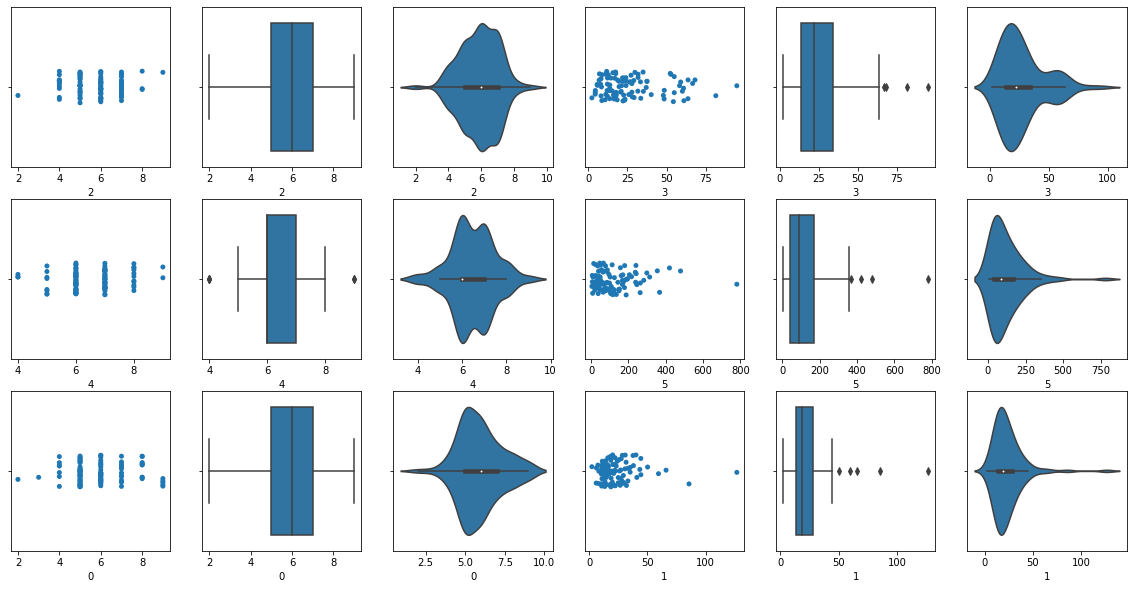

In [81]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 6,figsize=(20, 10))
for i in range(0,6,2):
    plotData = df.iloc[i]
    timeData = df.iloc[i+1]
    functions = [sns.stripplot, sns.boxplot, sns.violinplot]
    for j, func in enumerate(functions):
        func(plotData, ax=axes[(i-1)//2, j])
    for j, func in enumerate(functions):
        func(timeData, ax=axes[(i-1)//2, j+3])


ELECTRONIC MASTERMIND 1977
SELECT CODE TYPE: [3, 4, 5]: 3
Guess 0: 1 3 2
[0 0] ['.' '.' '.']
#GEN 1 : 0.49
#GEN 2 : 0.6
#GEN 3 : 0.54
Guess 1: 8 9 6
[0 0] ['.' '.' '.']


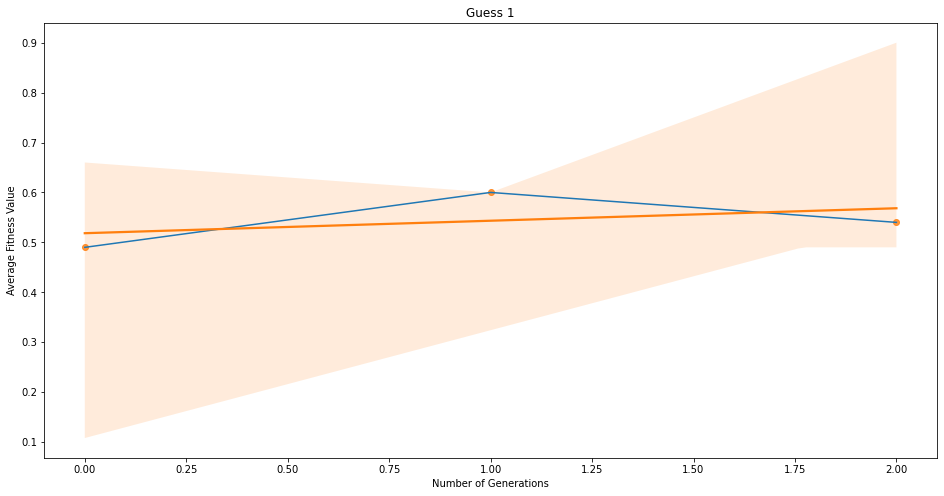

#GEN 1 : 0.43
#GEN 2 : 0.445
#GEN 3 : 0.485
#GEN 4 : 0.45
#GEN 5 : 0.435
#GEN 6 : 0.405
#GEN 7 : 0.46
#GEN 8 : 0.41
#GEN 9 : 0.425
#GEN 10 : 0.45
#GEN 11 : 0.395
#GEN 12 : 0.445
#GEN 13 : 0.42
#GEN 14 : 0.415
#GEN 15 : 0.42
#GEN 16 : 0.42
#GEN 17 : 0.43
#GEN 18 : 0.435
#GEN 19 : 0.435
#GEN 20 : 0.415
#GEN 21 : 0.41
#GEN 22 : 0.415
#GEN 23 : 0.42
#GEN 24 : 0.445
#GEN 25 : 0.435
#GEN 26 : 0.435
#GEN 27 : 0.375
#GEN 28 : 0.42
#GEN 29 : 0.445
#GEN 30 : 0.4
#GEN 31 : 0.475
#GEN 32 : 0.43
#GEN 33 : 0.43
#GEN 34 : 0.42
#GEN 35 : 0.425
#GEN 36 : 0.4
#GEN 37 : 0.43
#GEN 38 : 0.43
#GEN 39 : 0.43
#GEN 40 : 0.415
#GEN 41 : 0.445
#GEN 42 : 0.42
#GEN 43 : 0.44
#GEN 44 : 0.415
#GEN 45 : 0.435
#GEN 46 : 0.43
#GEN 47 : 0.4
#GEN 48 : 0.37
#GEN 49 : 0.455
#GEN 50 : 0.42
#GEN 51 : 0.445
#GEN 52 : 0.44
#GEN 53 : 0.42
#GEN 54 : 0.465
#GEN 55 : 0.41
#GEN 56 : 0.46
#GEN 57 : 0.43
#GEN 58 : 0.435
#GEN 59 : 0.39
#GEN 60 : 0.405
#GEN 61 : 0.48
#GEN 62 : 0.44
#GEN 63 : 0.445
#GEN 64 : 0.38
#GEN 65 : 0.435
#GEN 66

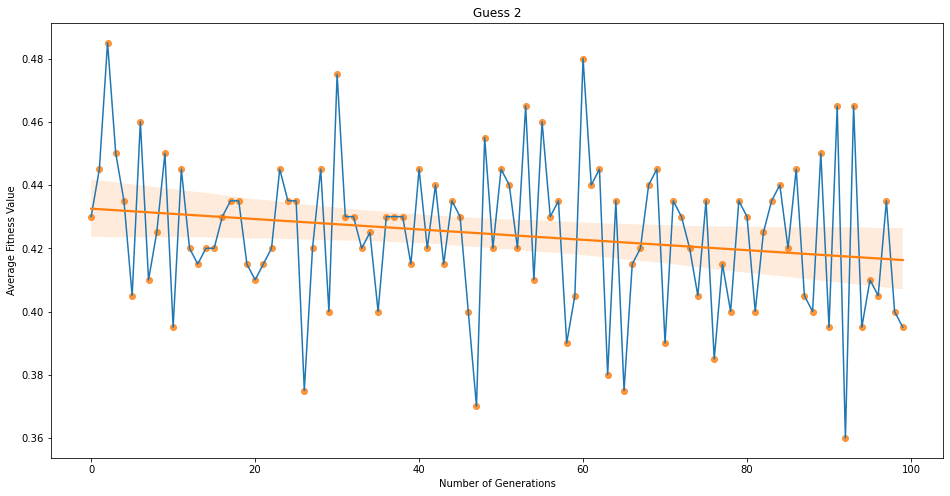

#GEN 1 : 0.44
#GEN 2 : 0.43333333333333335
#GEN 3 : 0.4433333333333333
#GEN 4 : 0.45
#GEN 5 : 0.3933333333333333
#GEN 6 : 0.3666666666666667
#GEN 7 : 0.4099999999999999
#GEN 8 : 0.4033333333333334
#GEN 9 : 0.4
#GEN 10 : 0.40666666666666673
#GEN 11 : 0.40333333333333327
#GEN 12 : 0.46333333333333326
#GEN 13 : 0.42
#GEN 14 : 0.40333333333333327
#GEN 15 : 0.4
#GEN 16 : 0.4
#GEN 17 : 0.4233333333333333
#GEN 18 : 0.42666666666666664
#GEN 19 : 0.4066666666666666
#GEN 20 : 0.46
#GEN 21 : 0.41
#GEN 22 : 0.4066666666666666
#GEN 23 : 0.42333333333333334
#GEN 24 : 0.35999999999999993
#GEN 25 : 0.43666666666666665
#GEN 26 : 0.42666666666666664
#GEN 27 : 0.41
#GEN 28 : 0.44
#GEN 29 : 0.44
#GEN 30 : 0.4333333333333333
#GEN 31 : 0.43333333333333335
#GEN 32 : 0.43333333333333335
#GEN 33 : 0.4233333333333333
#GEN 34 : 0.40333333333333327
#GEN 35 : 0.3766666666666667
#GEN 36 : 0.41666666666666674
#GEN 37 : 0.42999999999999994
#GEN 38 : 0.4
#GEN 39 : 0.39
#GEN 40 : 0.42666666666666664
#GEN 41 : 0.4433333

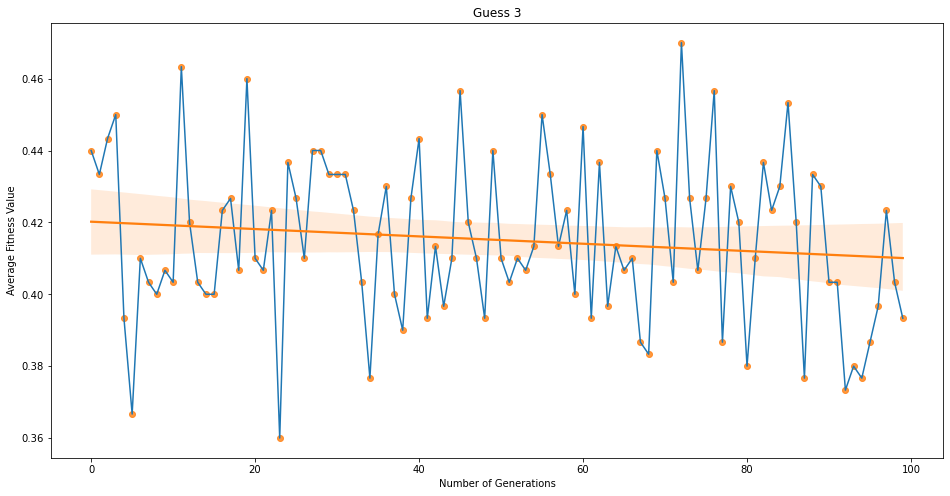

#GEN 1 : 0.575
#GEN 2 : 0.6175
#GEN 3 : 0.6175
#GEN 4 : 0.625
#GEN 5 : 0.58
#GEN 6 : 0.59
#GEN 7 : 0.63
#GEN 8 : 0.5925
#GEN 9 : 0.615
#GEN 10 : 0.61
#GEN 11 : 0.62
#GEN 12 : 0.6125
#GEN 13 : 0.5725
#GEN 14 : 0.615
#GEN 15 : 0.61
#GEN 16 : 0.5975
#GEN 17 : 0.6025
#GEN 18 : 0.59
#GEN 19 : 0.5925
#GEN 20 : 0.63
#GEN 21 : 0.605
#GEN 22 : 0.575
#GEN 23 : 0.5925
#GEN 24 : 0.6075
#GEN 25 : 0.615
#GEN 26 : 0.605
#GEN 27 : 0.6225
#GEN 28 : 0.6075
#GEN 29 : 0.585
#GEN 30 : 0.59
#GEN 31 : 0.6175
#GEN 32 : 0.595
#GEN 33 : 0.625
#GEN 34 : 0.605
#GEN 35 : 0.6075
#GEN 36 : 0.5825
#GEN 37 : 0.6125
#GEN 38 : 0.605
#GEN 39 : 0.635
#GEN 40 : 0.625
#GEN 41 : 0.6275
#GEN 42 : 0.625
#GEN 43 : 0.625
#GEN 44 : 0.6175
#GEN 45 : 0.6125
#GEN 46 : 0.6025
#GEN 47 : 0.575
#GEN 48 : 0.61
#GEN 49 : 0.61
#GEN 50 : 0.635
#GEN 51 : 0.5825
#GEN 52 : 0.6125
#GEN 53 : 0.6175
#GEN 54 : 0.5925
#GEN 55 : 0.62
#GEN 56 : 0.6225
#GEN 57 : 0.585
#GEN 58 : 0.6125
#GEN 59 : 0.6125
#GEN 60 : 0.6025
#GEN 61 : 0.63
#GEN 62 : 0.6175
#

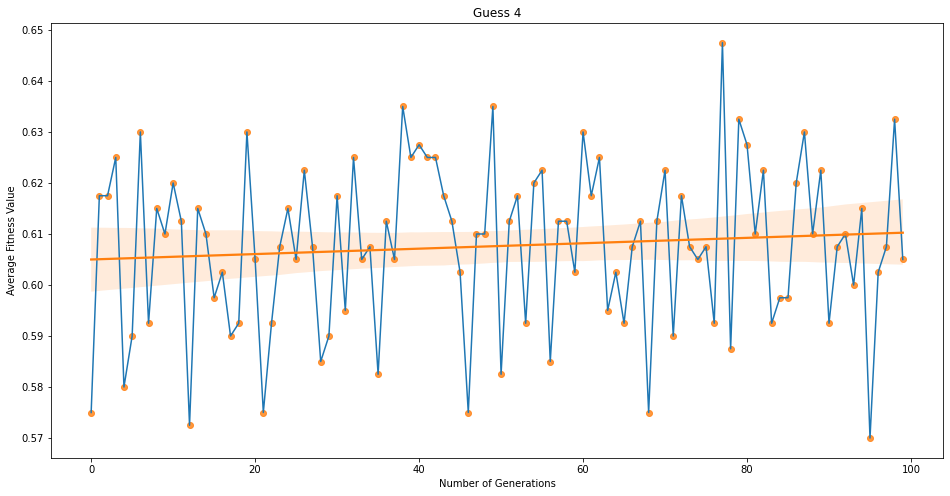

YOU WIN!


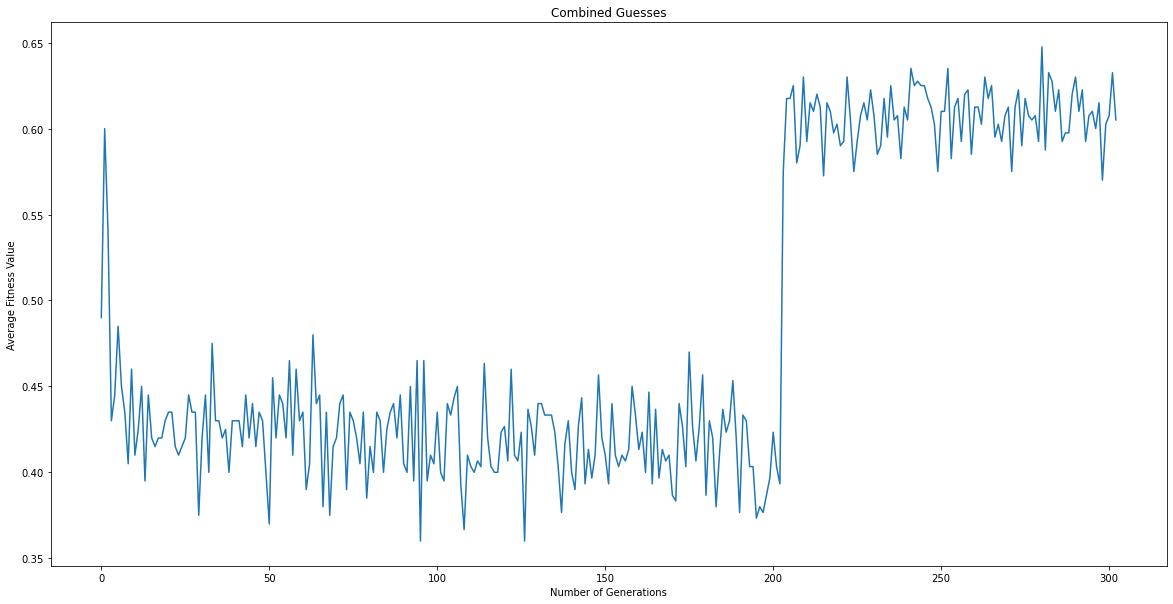

In [16]:
# Generates Probability Values in Array of size :param size:
def p(*size): return np.random.random(size=size if len(size) else 1)

# Generates Mastermind Values in Array of size :param size:
def rand(*size): return np.random.randint(N+1, size=size if len(size) else 1)

# Shuffles :param arr:
def shuffle(arr):
    cp = arr.copy()
    np.random.shuffle(cp)
    return cp


# Abstract Code Class
class Code(list):
    def __init__(self, *args):
        if len(args) == 1: args = args[0]
        super().__init__(map(int, args))
        self.values = np.array(self).flatten()

    @classmethod
    def randomize(cls, slots=3):
        return cls(rand(slots))

    @classmethod
    def randomDistinct(cls, size=POPSIZE, slots=SLOTS, initial=[]):
        df = pd.DataFrame(initial)
        while len(df) < size:
            pop = rand(size-len(df), slots)
            df = pd.concat([df, pd.DataFrame(pop)], ignore_index=True).drop_duplicates()
        return [cls(i) for i in df.iloc[:size].values]

    def __repr__(self):
        return f"Code("+super().__repr__()[1:-1]+")"

    def __setitem__(self, i, obj):
        super().__setitem__(i, obj)
        self.values = np.array(self)

    def randSlots(self, size=1, **kwargs):
        return np.random.choice(len(self)-1, size=size, **kwargs)

    def stringify(self):
        return "".join(map(str, self))

    @classmethod
    def destringify(cls, string):
        return cls(*map(int, string))

    def __hash__(self):
        return int(self.stringify())

    def abstractSwap(self, other=None, a=None, b=None):
        if other is None: other = self
        if a is None: a = self.randSlots()[0]
        if b is None: b = self.randSlots()[0]
        p1, p2 = map(np.array, [self, other])
        self[a], other[b] = self[b], other[a]
        return Chromosome(self), Chromosome(other)
    
    def mark(self, secret):
        guess = self.values
        secret = secret.values if hasattr(secret, "values") else np.array(secret)
        
        output = np.full_like(guess, ".", dtype=str)
        output[guess == secret] = "B"
        intersection = Counter(guess[guess != secret]) & Counter(secret[guess != secret])

        for i in np.where(guess != secret)[0]:
            if guess[i] in intersection:
                output[i] = "W"
                intersection -= Counter([guess[i]])

        return output
    
    def score(self, secret):
        guess = self.values
        secret = secret.values if hasattr(secret, "values") else np.array(secret)
        return np[(guess==secret).sum(), sum((Counter(guess[guess != secret]) & Counter(secret[guess != secret])).values())]
    
    def fitness(self, guesses):
        return np.array([np.abs(guess.score(self)-guess_result) for (guess, guess_result) in guesses]).mean()


class Chromosome(Code):
    def __init__(self, *args):
        super().__init__(*args)
        
    
    ## Crossover Methods
        
    def uniform_crossover(self, other, puniformcross=UNIFORM_CROSSOVER_PROBABILITY):
        return Chromosome(np.where(p(len(self))<puniformcross, self, other))
        
    def double_crossover(self, other, pdoublecross=DOUBLE_CROSSOVER_PROBABILITY):
        sec = slice(*sorted(self.randSlots(2,replace=False)))
        return self.abstractSwap(other, sec, sec)[0] if p() < pdoublecross else self
        
    def single_start_crossover(self, other, psinglestartcross=SINGLESTART_CROSSOVER_PROBABILITY):
        pos = self.randSlots()[0]
        return self.abstractSwap(other, slice(pos), slice(pos))[0] if p() < psinglestartcross else self
        
    def single_end_crossover(self, other, psingleendcross=SINGLEEND_CROSSOVER_PROBABILITY):
        pos = self.randSlots()[0]
        return self.abstractSwap(other, slice(pos, len(self)), slice(pos, len(self)))[0] if p() < psingleendcross else self
    
    def cross(self, other, puniformcross=UNIFORM_CROSSOVER_PROBABILITY, pdoublecross=DOUBLE_CROSSOVER_PROBABILITY, psinglestartcross=SINGLESTART_CROSSOVER_PROBABILITY, psingleendcross=SINGLEEND_CROSSOVER_PROBABILITY):
        uni = self.uniform_crossover(other, puniformcross)
        #print("Uniform", uni)
        double = uni.double_crossover(other, pdoublecross)
        #print("Double", double)
        singlestart = double.single_start_crossover(other, psinglestartcross)
        #print("Single Start", singlestart)
        singleend = singlestart.single_end_crossover(other, psingleendcross)
        #print("Single End", singleend)
        return singleend
    
    ## Mutation Methods
    
    def bitflip(self, pbitflip=BITFLIP_PROBABILITY):
        #print("bitflip length", len(self))
        return self.abstractSwap(rand(len(self)))[0]
    
    def invert(self, pinvert=INVERT_PROBABILITY):
        a, b = sorted(self.randSlots(2, replace=True))    
        return self.abstractSwap(self, slice(a,b), slice(b, a, -1))[0] if p() < pinvert else self
    
    def scramble(self, pscramble=SCRAMBLE_PROBABILITY):
        code = np.array(self)
        if p() < pscramble:
            sec = slice(*sorted(self.randSlots(2)))
            code[sec] = shuffle(code[sec])
        return Chromosome(code)
    
    def permute(self, ppermute=PERMUTE_PROBABILITY):
        return self.abstractSwap(self, *self.randSlots(2, replace=False))[0] if p() < ppermute else self
    
    def mutate(self, pbitflip=BITFLIP_PROBABILITY, pinvert=INVERT_PROBABILITY, pscramble=SCRAMBLE_PROBABILITY, ppermute=PERMUTE_PROBABILITY):
        return self.bitflip(pbitflip).invert(pinvert).scramble(pscramble).permute(ppermute)
    

class ChromoSet(list):
    def __init__(self, values=[]):
        self.values = [Chromosome(candidate) for candidate in np.array(values).tolist()]
        super().__init__(self.values)
    
    def filter(self, f):
        return Elite([chromosome for chromosome in self if f(chromosome)])
    
class Elite(ChromoSet):
    def __add__(self, other):
        return Elite(list(set(self) | set(other)))
    def __sub__(self, other):
        return Elite(list(set(self) - set(other)))
    def __str__(self):
        return "["+", ".join(map(str, self))+"]"
    def __repr__(self):
        return "["+", ".join(map(str, self))+"]"
        
        
class Genotype(ChromoSet):
    def __init__(self, size, slots, initial=[], guesses_list=None):
        if guesses_list is None: guesses_list = guesses
        self.slots = slots
        self.size = size
        super().__init__(Code.randomDistinct(size=size, slots=slots, initial=[]))
        self.fitnesses = np.array(list(map(partial(Code.fitness, guesses=guesses_list), self)))
    
    def sortedByFitness(self):
        return sorted(zip(self, self.fitnesses),key=lambda a:a[0])
    
    def parents(self, n_parents=NUM_PARENTS):
        return self.sortedByFitness()[:n_parents]
    
    def isZero(self):
        return Elite([self[i] for i in np.where(self.fitnesses == 0)[0]])
        
    def breed(self, guesses, n_parents=NUM_PARENTS, elitism_rate=ELITISM_RATE):
        parents_pool = self.parents(n_parents)
        
        children = parents_pool[:elitism_rate]
        for i in range(len(self)-len(children)):
            p1 = parents_pool[int(p() * n_parents)][0]
            p2 = parents_pool[int(p() * n_parents)][0]
            #print(p1, p2)
            crossed = p1.cross(p2)
            #print("Cross", crossed)
            mutated = crossed.mutate()
            #print("Mutate", mutated)
            children.append(mutated)
        
        return Genotype(len(children), self.slots, initial=children), np.mean([i[1] for i in parents_pool])

if __name__ == "__main__":
    code_type = input("ELECTRONIC MASTERMIND 1977\nSELECT CODE TYPE: [3, 4, 5]: ").strip()
    SLOTS = int(code_type)
    N = 9
    UNIFORM_CROSSOVER_PROBABILITY = 0.5
    SINGLESTART_CROSSOVER_PROBABILITY = 0.5
    SINGLEEND_CROSSOVER_PROBABILITY = 0.5
    DOUBLE_CROSSOVER_PROBABILITY = 0.5
    BITFLIP_PROBABILITY = 0.03
    PERMUTE_PROBABILITY = 0.03
    SCRAMBLE_PROBABILITY = 0.03
    INVERT_PROBABILITY = 0.03
    NUM_PARENTS = 50
    MAX_GENERATIONS = 100
    POPSIZE = 150
    SLOTS = 3
    ELITISM_RATE = 50
    MAX_GUESS = 20
    MAX_ELITES = 100

    code = Code.randomize(SLOTS)
    init = Code.randomize(SLOTS)

    print("Guess 0:", *init)
    print(code.score(init), code.mark(init))
    guesses = [(init, code.score(init))]

    cnt = 1

    stored = []

    while cnt <= MAX_GUESS and guesses[-1][-1][0] != SLOTS:
        stored_i = len(stored)
        pop = Genotype(POPSIZE, SLOTS, [i[0] for i in guesses])
        #print(pop)
        Ei = Elite()
        gens = 1
        while gens <= MAX_GENERATIONS and len(Ei) < MAX_ELITES:
            children, avg_score = pop.breed(guesses=guesses)
            #eligibles = children.filter(lambda child: child.fitness(guesses) == 0)
            eligibles = children.isZero()
            if len(children):
                Ei = Ei + eligibles
                pop = Genotype(POPSIZE, SLOTS, initial=Ei)
                #avg_score = np.mean(pop.fitnesses(guesses))
                stored.append(avg_score)
                print("#GEN", gens, ":", avg_score)
                gens += 1
        if len(Ei) == 0: continue
        possibles = Ei - Elite([i[0] for i in guesses])
        submission = possibles[np.random.randint(len(possibles))]
        print(f"Guess {cnt}:", *submission)
        print(code.score(submission), code.mark(submission))
        guesses.append((submission, code.score(submission)))
        plt.figure(figsize=(16,8))
        plt.plot(stored[stored_i:])
        sns.regplot(x=np.arange(len(stored[stored_i:])), y=stored[stored_i:])
        plt.title(f"Guess {cnt}")
        plt.xlabel("Number of Generations")
        plt.ylabel("Average Fitness Value")
        plt.show()
        cnt += 1

    print("YOU WIN!")
    #return cnt
    plt.figure(figsize=(20,10))
    plt.plot(stored)
    plt.title(f"Combined Guesses")
    plt.xlabel("Number of Generations")
    plt.ylabel("Average Fitness Value")
    plt.show()

